In [95]:
from skimage import data
from skimage.exposure import histogram
import tifffile
import matplotlib.pyplot as plt
import os
import sys
from skimage import data, feature, exposure
import numpy as np
from skimage.filters import threshold_otsu
import threading
import logging
import time
from pathlib import Path

# def scale_to(x, x_min, x_max, dtype):
#     r = x_max - x_min
#     t_max = np.iinfo(np.dtype(dtype)).max
#     # assert(math.isclose(0,r, abs_tol=np.finfo(float).eps) == False)
#     x_s =  ((x - x_min) / r) * t_max
#     return x_s
# path = "D:\\Data\\Sudipta\\Arpan"
# file_name = "single_frame_send_1.tif"


def scale_to(x,  dtype):
    r = np.max(x) - np.min(x)
    try:
        t_max = np.iinfo(np.dtype(dtype)).max
    except:
        t_max = np.finfo(np.dtype(dtype)).max
    
    # assert(math.isclose(0,r, abs_tol=np.finfo(float).eps) == False)
    x_s =  ((x - np.min(x)) / r) * t_max
    return x_s.astype(dtype)

def scale_to_float(x,  dtype_in):
#     r = np.max(x) - np.min(x)
    try:
        i_min = np.iinfo(np.dtype(dtype_in)).min
        i_max = np.iinfo(np.dtype(dtype_in)).max
    except:
        i_min = np.finfo(np.dtype(dtype_in)).min
        i_max = np.finfo(np.dtype(dtype_in)).max
    
    r = i_max -i_min
    return (x - i_min)/r

def subtract(a, b, dtype='uint16'):
    try:
        t_min = np.iinfo(np.dtype(dtype)).min
        t_max = np.iinfo(np.dtype(dtype)).max
    except:
        t_min = np.finfo(np.dtype(dtype)).min
        t_max = np.finfo(np.dtype(dtype)).max        
    return np.clip(a.astype('int32') - b, t_min, t_max).astype(a.dtype)

def top_hat(image, radius=50, light_bg=False):
        from skimage.morphology import white_tophat, black_tophat, disk
        str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
        if light_bg:
            return  scale_to(black_tophat(image, str_el), image.dtype)
        else:
            return  scale_to(white_tophat(image, str_el), image.dtype)


from skimage.draw import disk
from math import sqrt
def draw_points(image, points, radius=1):
    # points = points[:,:2]
    def map_bound(limit):
        def fun(val):
            # logging.info("befor: limit %d. val %d", limit, val)
            if val >= limit: 
                val = limit-1
            elif val < 0:
                val = 0
            # logging.info("after: limit %d. val %d", limit, val)
            return val
        return fun

    for x, y, r in points:
        rr, cc = disk((x,y), radius=r*sqrt(2))
        rr = np.array(list(map(map_bound(image.shape[0]), rr)), dtype='uint16')
        cc = np.array(list(map(map_bound(image.shape[1]), cc)), dtype='uint16')
        image[rr, cc] = 255
    return image

def get_mask(input, result, index):
    logging.info("Processing %d ", index)
    points = find_points(input)
    mask = draw_points(result[index], points)
    result[index] = mask

def get_mask_v2(input, radius=1):
    points = find_points(input)
    return draw_points(np.zeros(input.shape, dtype=input.dtype), points, radius)
    


In [96]:
data_path = 'E:\\Sudipta\\Arpan\\ML_Data\\single_frame_6'

In [97]:
def find_points(image):
    # equalize_hist_img = exposure.equalize_hist(image)
    thresh = threshold_otsu(image)
    thresh_img = subtract(image, thresh, image.dtype)
    top_hat_img = top_hat(thresh_img, radius=5)
    blobs = feature.blob_log(top_hat_img,overlap=0.9, threshold=0.1)
    # return blobs[:, :2]
    return blobs


In [98]:
def test(input):
    data  = tifffile.imread(os.path.join(input, "*.tif*"))
    result = np.zeros(data.shape, dtype=data.dtype)
    logging.basicConfig(format="%(asctime)s: %(message)s", level=logging.INFO, datefmt="%H:%M:%S")
    
    logging.info("Starting the test")
    # mask = get_mask_v2, [data[i] for i in range(data.shape[0])]
    points = find_points(data)
    print(points)
    logging.info("End")

In [99]:
test(data_path)

02:29:39: TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
02:29:39: Starting the test
02:29:39: End


[[ 90.  95.   1.]
 [ 83.  92.   1.]
 [ 56.  65.   1.]
 [ 99.  51.   1.]
 [ 89. 109.   1.]
 [ 74.  82.   1.]
 [110.  71.   1.]
 [127.  74.   1.]
 [110.  59.   1.]
 [ 91. 114.   1.]
 [ 97.  59.   1.]
 [ 88.  48.   1.]
 [ 38. 135.   1.]
 [ 40.  39.   1.]]


In [52]:
def plot_multi(images):
    fig, ax = plt.subplots(ncols=len(images), figsize=(20, 8))
    for i, image in enumerate(images.items()):
        ax[i].set_title(str(image[0]))
        ax[i].imshow(image[1], clim=[np.min(image[1]), np.max(image[1])], cmap='gray')
    plt.show()

01:54:34: TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


[[4.97807319e-04 5.54519028e-04 7.28808010e-05 ... 4.31590314e-05
  2.15929987e-04 1.45161346e-04]
 [4.52816456e-04 1.90775917e-04 7.19766623e-05 ... 2.18376009e-04
  1.12648379e-04 1.98513952e-04]
 [3.00398369e-04 2.52955972e-04 2.54475930e-04 ... 2.66159511e-04
  7.33782866e-05 3.00398369e-04]
 ...
 [1.49214978e-04 1.02644572e-04 1.35839580e-04 ... 2.71518420e-04
  1.70814169e-04 1.68886424e-04]
 [5.04615877e-04 4.08392691e-04 3.01582900e-04 ... 7.86431988e-05
  1.65623662e-04 9.15541314e-05]
 [6.28509184e-04 9.56735806e-05 5.96957432e-04 ... 1.00132790e-04
  1.84533251e-04 1.45761602e-04]]
1120


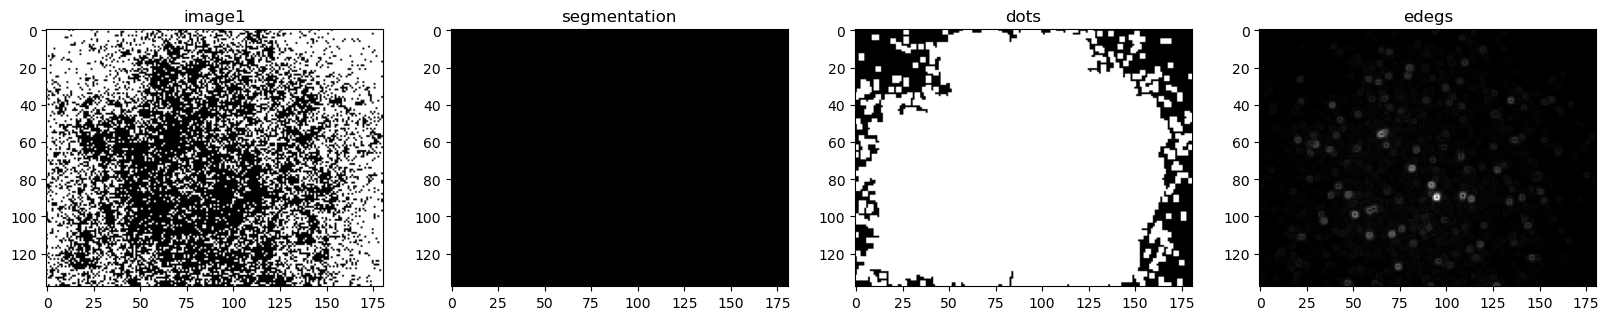

In [67]:
# !matplotlib notebook
import matplotlib.pyplot as plt
from skimage import data, filters
from scipy import ndimage as ndi
from skimage.segmentation import watershed

image  = tifffile.imread(os.path.join(data_path, "*.tif*"))
thresh = threshold_otsu(image)
thresh_img = subtract(image, thresh, image.dtype)
top_hat_img = top_hat(thresh_img, radius=5)
edges = filters.sobel(top_hat_img)
dots = ndi.binary_fill_holes(edges)

elevation_map = filters.sobel(image)
print(elevation_map)

markers = np.zeros_like(image)
markers[image < (thresh-200)] = 1
markers[image > thresh] = 2
print(thresh)

segmentation = watershed(elevation_map, markers)
# segmentation = ndi.binary_fill_holes(segmentation - 1)
# low = threshold_otsu(edges)
# lowt = (edges > low).astype(int)
# print(lowt)
# plt.imshow(edges)
plot_multi({"image1":image<thresh-20,"segmentation":segmentation, "dots":dots, "edegs":edges})


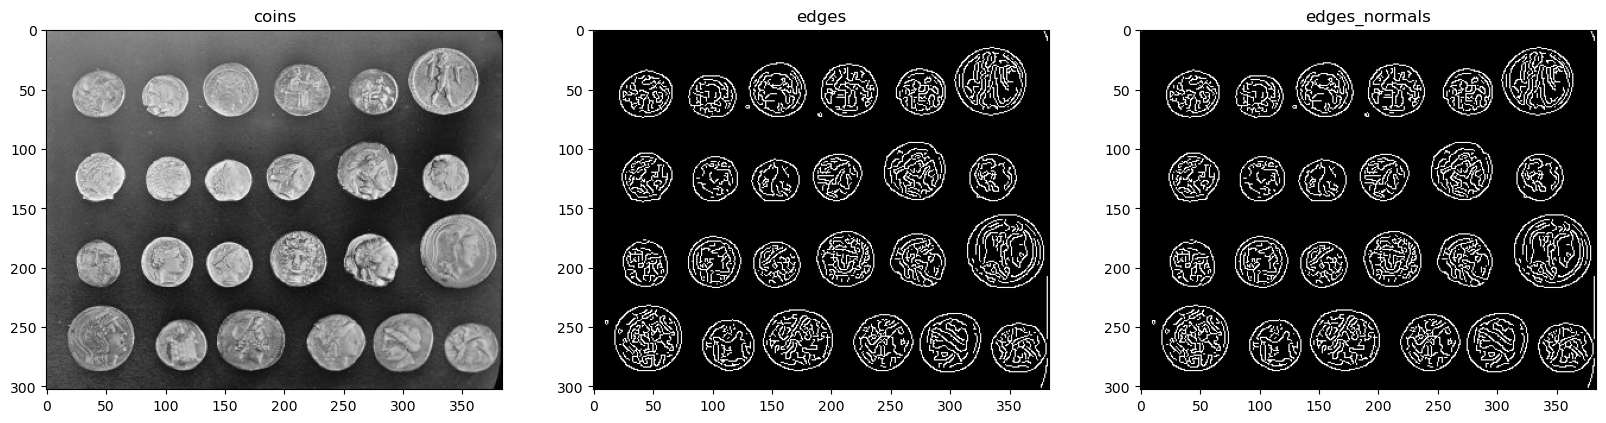

In [72]:
from skimage import data
from skimage.exposure import histogram
from skimage.feature import canny
edges = canny(coins/255.)
coins = data.coins()
hist, hist_centers = histogram(coins)
edges = canny(coins/255.)
edges_normals = canny(coins)
plot_multi({"coins":coins, "edges":edges, "edges_normals": edges_normals})

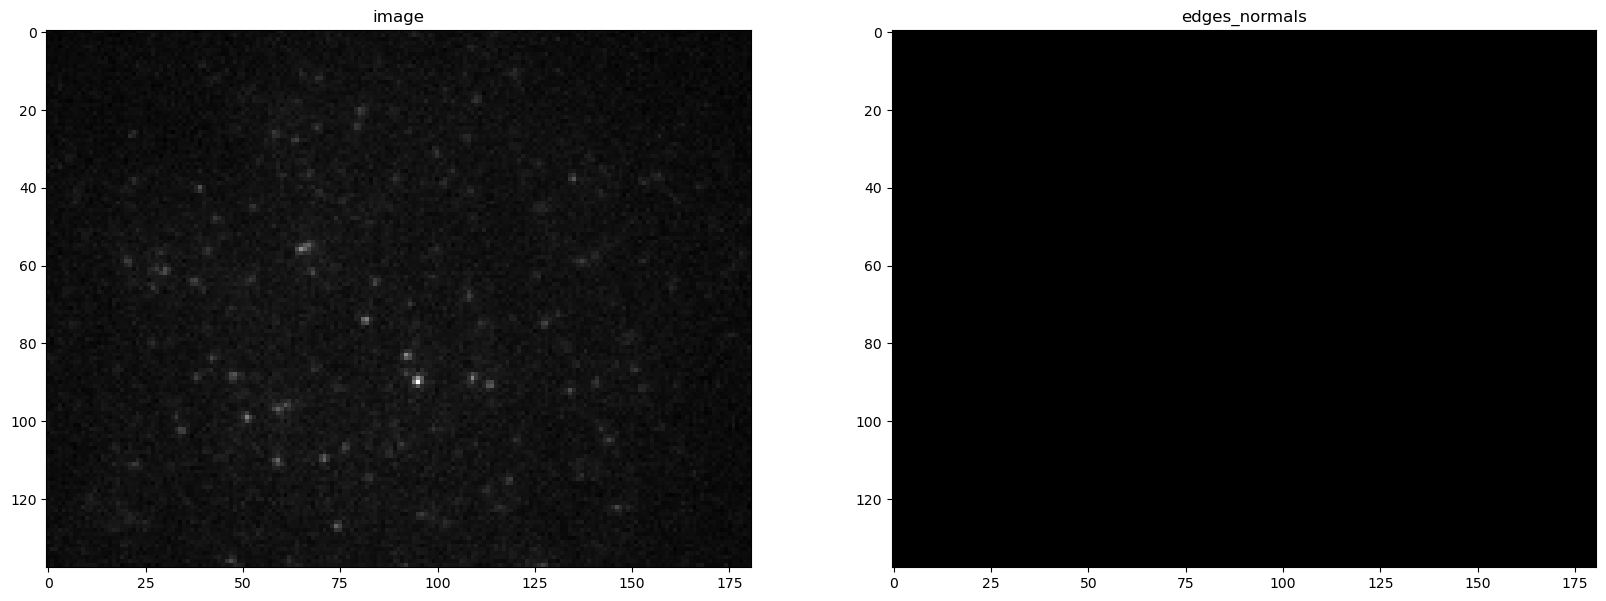

In [76]:
edges_normals = canny(image, sigma=0.1)
plot_multi({"image":image, "edges_normals": edges_normals})

02:15:05: TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


[[ 90.  95.   1.]
 [ 83.  92.   1.]
 [ 56.  65.   1.]
 [ 99.  51.   1.]
 [ 89. 109.   1.]
 [ 74.  82.   1.]
 [110.  71.   1.]
 [127.  74.   1.]
 [110.  59.   1.]
 [ 91. 114.   1.]
 [ 97.  59.   1.]
 [ 88.  48.   1.]
 [ 38. 135.   1.]
 [ 40.  39.   1.]]
[[ 90.  95.   1.]
 [ 83.  92.   1.]
 [ 56.  65.   1.]
 [ 74.  82.   1.]
 [ 99.  51.   1.]
 [ 89. 109.   1.]
 [110.  71.   1.]]
[[89. 94.  1.]]
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


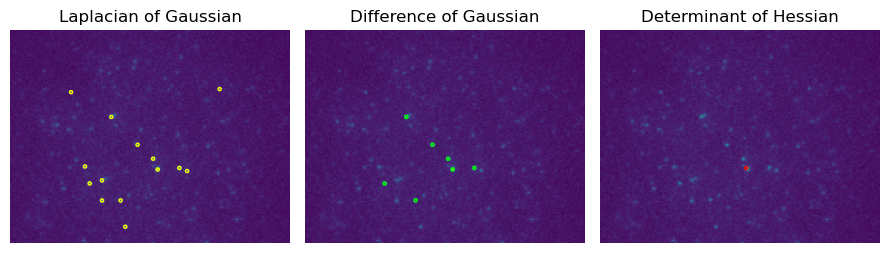

In [82]:
image  = tifffile.imread(os.path.join(data_path, "*.tif*"))
thresh = threshold_otsu(image)
thresh_img = subtract(image, thresh, image.dtype)
top_hat_img = top_hat(thresh_img)

blobs_log = feature.blob_log(top_hat_img,  overlap=0.9, threshold=0.1)

blobs_dog = feature.blob_dog(top_hat_img,  threshold=.1)

blobs_doh = feature.blob_doh(top_hat_img,  threshold=.01)
print(blobs_log)
print(blobs_dog)
print(blobs_doh)
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        print(r)
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

[[356.         485.           7.44444444]
 [ 44.         262.           1.        ]
 [427.         420.           1.        ]
 [ 23.         439.           1.        ]
 [309.         291.           4.22222222]
 [391.         161.           1.        ]
 [358.          32.           1.        ]
 [289.         448.           1.        ]
 [149.         445.           7.44444444]
 [129.         390.           1.        ]]


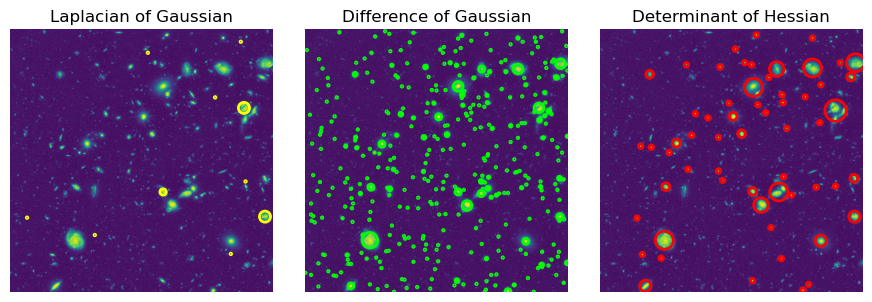

In [94]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log = blobs_log[10:20,]
print(blobs_log)
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()